## Comparison between three classic option pricing models


---

### Black-Scholes Formula (European)

**Call Option Price:**

$$
C = S \cdot N(d_1) - K e^{-rT} \cdot N(d_2)
$$

**Put Option Price:**

$$
P = K e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1)
$$

Where:

$$
d_1 = \frac{\ln(S/K) + (r + \frac{1}{2} \sigma^2) T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}
$$

**Delta of Call (hedge ratio):**  
$\Delta_{\text{call}} = N(d_1)$

---

### Binomial Tree Option Pricing (European)

**Stock price movements:**

$$
u = e^{\sigma \sqrt{\Delta t}}, \quad d = \frac{1}{u}, \quad \Delta t = \frac{T}{N}
$$

**Risk-neutral probability:**

$$
p = \frac{e^{r \Delta t} - d}{u - d}
$$

**Backward induction at node $(i, j)$:**

$$
V_{i,j} = e^{-r \Delta t} \left[ p \cdot V_{i+1,j+1} + (1 - p) \cdot V_{i+1,j} \right]
$$

---

### Monte Carlo Pricing (European)

**Simulate asset price at maturity:**

$$
S_T = S \cdot e^{(r - \frac{1}{2} \sigma^2) T + \sigma \sqrt{T} Z}, \quad Z \sim \mathcal{N}(0,1)
$$

**Call Payoff:**  
$\text{Payoff} = \max(S_T - K, 0)$

**Put Payoff:**  
$\text{Payoff} = \max(K - S_T, 0)$

**Option Price (Expected PV):**

$$
V = e^{-rT} \cdot \mathbb{E}[\text{Payoff}]
$$


In [41]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Pricers
# Black-Scholes pricer
def black_scholes_price(S, K, T, r, sigma, verbose = False):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    c = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    p = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    if verbose:
        print(f'Intermediate values: d1 = {round(d1, 3)}, d2 = {round(d2, 3)}')
    return c, p

# Binomial Tree pricer
def binomial_tree_price(S, K, T, r, sigma, N, verbose = False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    asset_tree = np.zeros((N + 1, N + 1))
    call_tree = np.zeros((N + 1, N + 1))
    put_tree = np.zeros((N + 1, N + 1))
    
    # Fill asset prices
    for i in range(N + 1):
        for j in range(i + 1):
            asset_tree[j, i] = S * (u ** j) * (d ** (i - j))
    
    # Fill option values at maturity (step N)
    for j in range(N + 1):
        put_tree[j, N] = max(K - asset_tree[j, N], 0)
        call_tree[j, N] = max(asset_tree[j, N] - K, 0)

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            call_tree[j, i] = discount * (p * call_tree[j + 1, i + 1] + (1 - p) * call_tree[j, i + 1])
            put_tree[j, i] = discount * (p * put_tree[j + 1, i + 1] + (1 - p) * put_tree[j, i + 1])
            
    c = call_tree[0, 0]
    p = put_tree[0, 0]
             
    if verbose:
        # Display as DataFrame for visualization
        df_assets = pd.DataFrame(asset_tree, columns=[f"Step {i}" for i in range(N+1)])
        df_calls = pd.DataFrame(call_tree, columns=[f"Step {i}" for i in range(N+1)])
        df_puts = pd.DataFrame(put_tree, columns=[f"Step {i}" for i in range(N+1)])
        
        print("Asset Prices Tree:")
        print(df_assets.round(2))

        print("\nCall Option Prices Tree (Backward Induction):")
        print(df_calls.round(2))

        print("\nPull Option Prices Tree (Backward Induction):")
        print(df_puts.round(2))
    
    return c, p


# Monte Carlo pricer
def monte_carlo_price(S, K, T, r, sigma, simulations=1000):
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)

    call_payoffs = np.maximum(ST - K, 0)

    put_payoffs = np.maximum(K - ST, 0)
    
    c = np.exp(-r * T) * np.mean(call_payoffs)
    p = np.exp(-r * T) * np.mean(put_payoffs)
    return c, p



### A simple example for demonstration

In [39]:
# Parameters
S = 42          # Spot price
K = 40          # Strike price
T = 1           # Time to maturity
r = 0.05        # Risk-free rate
sigma = 0.2     # Volatility
N = 5           # Steps

print(f'BS pricer')
c, p = black_scholes_price(S, K, T, r, sigma, verbose = True)
print(f'call = {round(c, 3)}, put = {round(p, 3)}\n')

print(f'Binomial tree pricer')
c, p = binomial_tree_price(S, K, T, r, sigma, N, verbose = True)
print(f'call = {round(c, 3)}, put = {round(p, 3)}\n')

print(f'Monte Carlo pricer')
c, p = monte_carlo_price(S, K, T, r, sigma, simulations=1000)
print(f'call = {round(c, 3)}, put = {round(p, 3)}\n')

BS pricer
Intermediate values: d1 = 0.594, d2 = 0.394
call = 5.543, put = 1.592

Binomial tree pricer
Asset Prices Tree:
   Step 0  Step 1  Step 2  Step 3  Step 4  Step 5
0    42.0   38.41   35.12   32.12   29.37   26.86
1     0.0   45.93   42.00   38.41   35.12   32.12
2     0.0    0.00   50.23   45.93   42.00   38.41
3     0.0    0.00    0.00   54.93   50.23   45.93
4     0.0    0.00    0.00    0.00   60.07   54.93
5     0.0    0.00    0.00    0.00    0.00   65.69

Call Option Prices Tree (Backward Induction):
   Step 0  Step 1  Step 2  Step 3  Step 4  Step 5
0    5.61    2.78    0.88    0.00    0.00    0.00
1    0.00    8.19    4.50    1.66    0.00    0.00
2    0.00    0.00   11.57    7.06    3.13    0.00
3    0.00    0.00    0.00   15.72   10.63    5.93
4    0.00    0.00    0.00    0.00   20.46   14.93
5    0.00    0.00    0.00    0.00    0.00   25.69

Pull Option Prices Tree (Backward Induction):
   Step 0  Step 1  Step 2  Step 3  Step 4  Step 5
0    1.66    2.80    4.57    7.09  

### Compare three option pricers on different strikes

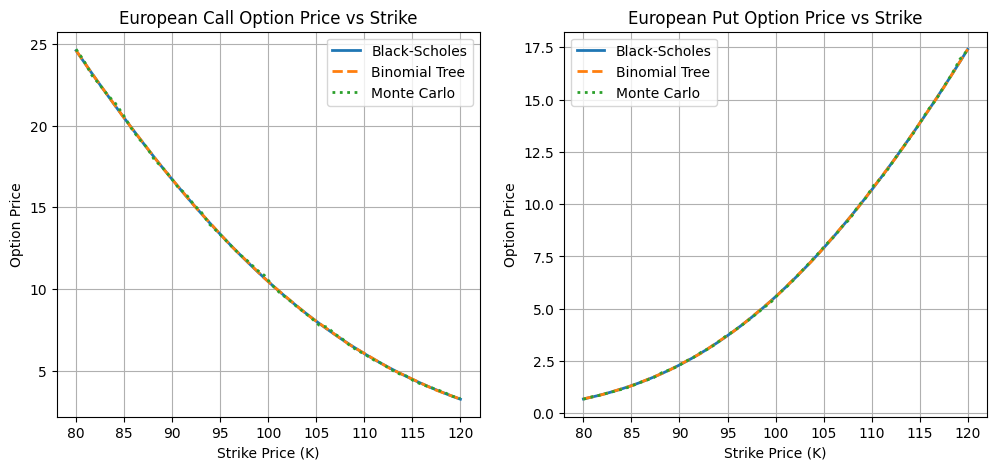

In [40]:
strikes = np.linspace(80, 120, 50)
S, T, r, sigma = 100, 1, 0.05, 0.2

# Initialize result containers
results = {
    "Call": {"bs": [], "bt": [], "mc": []},
    "Put": {"bs": [], "bt": [], "mc": []}
}

# Compute prices for both calls and puts across strikes
for K in strikes:
    call, put = black_scholes_price(S, K, T, r, sigma)     
    results['Call']["bs"].append(call), results['Put']["bs"].append(put)
    
    call, put = binomial_tree_price(S, K, T, r, sigma, 100) 
    results['Call']["bt"].append(call), results['Put']["bt"].append(put) 
    
    call, put = monte_carlo_price(S, K, T, r, sigma, 50000)
    results['Call']["mc"].append(call), results['Put']["mc"].append(put) 

# Plot for Call options
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(strikes, results["Call"]["bs"], label="Black-Scholes", lw=2)
plt.plot(strikes, results["Call"]["bt"], label="Binomial Tree", lw=2, linestyle='--')
plt.plot(strikes, results["Call"]["mc"], label="Monte Carlo", lw=2, linestyle=':')
plt.title("European Call Option Price vs Strike")
plt.xlabel("Strike Price (K)")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)

# Plot for Put options
plt.subplot(1, 2, 2)
plt.plot(strikes, results["Put"]["bs"], label="Black-Scholes", lw=2)
plt.plot(strikes, results["Put"]["bt"], label="Binomial Tree", lw=2, linestyle='--')
plt.plot(strikes, results["Put"]["mc"], label="Monte Carlo", lw=2, linestyle=':')
plt.title("European Put Option Price vs Strike")
plt.xlabel("Strike Price (K)")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
